# Considering CNOT gate error for PC(Z)

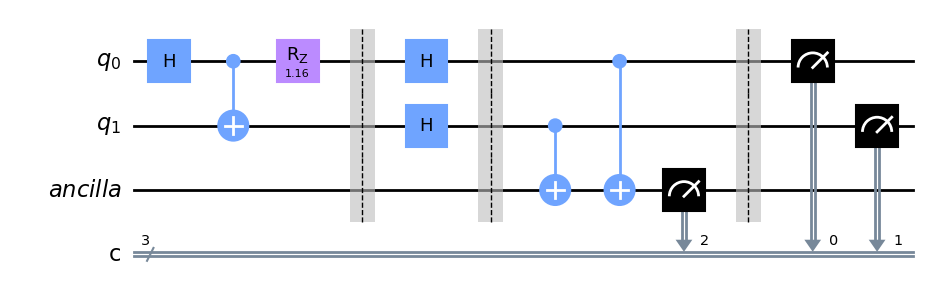

In [9]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute, Aer,transpile, assemble
from qiskit.quantum_info import Kraus, SuperOp, Operator, partial_trace, DensityMatrix
from qiskit.visualization import plot_bloch_multivector, plot_state_city
from qiskit.providers.aer.noise import amplitude_damping_error, pauli_error, depolarizing_error, NoiseModel
from qiskit.quantum_info import DensityMatrix, partial_trace, Pauli
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Markdown
from math import pi
q = QuantumRegister(2, 'q')
c = ClassicalRegister(3, 'c')
anc = QuantumRegister(1, 'ancilla') 
qc = QuantumCircuit(q,anc,c)

F = 0.7
Fth =2* math.acos(math.sqrt(F))
#####
qc.h(0)
qc.cx(0, 1)
qc.rz(Fth, 0)
#####
qc.barrier()
#qc.u(pi/4,0,0,2)

qc.h(0)
qc.h(1)
qc.barrier()
qc.cx(1, 2)
qc.cx(0, 2)
qc.measure([2],c[2])
################
#Depolarizing error of CNOT gate:
error_rate_cnot =0.05# Adjust this value based on the desired error rate

# Create a depolarizing error for the CNOT gate
cnot_error = depolarizing_error(error_rate_cnot, 2)

#To check that the error rate of the first CNOT gate has no effects on the fidelity you can set a different
#error rate for CNOT [0,1]:
cnot_error1 = depolarizing_error(0.8, 2)
# Create a noise model and add the CNOT error to it for the specified qubits
noise_model = NoiseModel()
noise_model.add_quantum_error(cnot_error, 'cx', [0,2]) 
noise_model.add_quantum_error(cnot_error, 'cx', [1,2])
noise_model.add_quantum_error(cnot_error, 'cx', [0,1])
#noise_model.add_quantum_error(cnot_error1, 'cx', [0,1])
qc.barrier()
#####
qc.measure([0,1],[0,1])
qc.draw('mpl')

In [10]:
Shots_n=100000
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method, noise_model=noise_model, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result
counts = result.get_counts()  # Get the measurement counts
print(counts)


{'000': 32116, '011': 32335, '101': 15191, '111': 1281, '110': 15299, '010': 1232, '100': 1282, '001': 1264}


<center>Obtaining maximally entangled state: $\phi_+$</center>

Fidelity= 0.9627139970840213


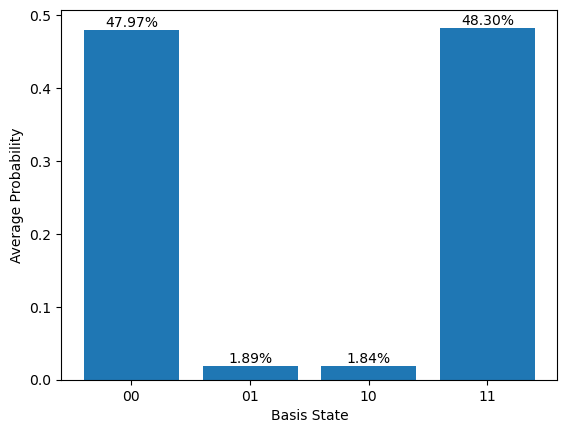

In [11]:
success, fail = 0, 0
Bell_states = {}
Bell_new= {}
for jj in counts:
        if (jj[0]=='0'  ): #obtaining phi+
            success += counts[jj]
            Bell_state = jj
            if Bell_state in Bell_states:
                Bell_states[Bell_state] += counts[jj]
            else:
                Bell_states[Bell_state] = counts[jj]
        else:
            fail += counts[jj]
            
total = success + fail

# Extract the last character from each Bell state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[1:]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]
        
        
# Define the text to be centered
text = "Obtaining maximally entangled state: $\phi_+$"
# Display the centered text using Markdown formatting
display(Markdown(f"<center>{text}</center>"))        


# Convert counts to a sorted list of probabilities
basis_states = ['00', '01', '10', '11']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states] # Normalized state


p11 = probabilities[basis_states.index('00')]
p44 = probabilities[basis_states.index('11')]
p14=np.sqrt(p11)*np.sqrt(p44)
Fid=1/2*(p11+p44)+p14
print('Fidelity=',Fid)


# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()